# Classification Metrics: Accuracy, Precision, Recall, and F1 Score

## Learning to Measure How Good Our Predictions Are

Imagine you're a fruit sorter at a grocery store. Your job is to look at fruits and decide if they are **apples** or **oranges**. Sometimes you get it right, sometimes you make mistakes. 

In this notebook, we'll learn how to measure how good our fruit-sorting skills are using four important metrics:

1. **Accuracy** - How often are we right overall?
2. **Precision** - When we say "apple," how often are we actually right?
3. **Recall** - Of all the real apples, how many did we find?
4. **F1 Score** - A balanced way to look at precision and recall together

Let's start by importing the tools we need.


In [77]:
# Import all the tools we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Make our plots look nice
plt.style.use('default')
sns.set_palette("husl")

print("✅ All tools loaded successfully")
print("🍎🍊 Ready to learn about apples and oranges")


✅ All tools loaded successfully
🍎🍊 Ready to learn about apples and oranges


## Step 1: Creating Our Fruit Dataset

Let's create a dataset of fruits with different characteristics. We'll use features like:
- **Color** (red, orange, yellow)
- **Size** (small, medium, large)
- **Texture** (smooth, rough)
- **Weight** (in grams)

This will help our computer learn to tell apples from oranges.


In [78]:
# Set a random seed so we get the same results every time
np.random.seed(42)

# Create our fruit dataset
data = []

# Create 200 apples
for i in range(200):
    # Apples are usually red, sometimes yellow
    color = np.random.choice(['red', 'yellow'], p=[0.8, 0.2])
    
    # Apples come in different sizes
    size = np.random.choice(['small', 'medium', 'large'], p=[0.2, 0.6, 0.2])
    
    # Apples are usually smooth
    texture = np.random.choice(['smooth', 'rough'], p=[0.9, 0.1])
    
    # Apple weight (grams)
    weight = np.random.normal(150, 30)  # Average 150g, some variation
    
    data.append({
        'color': color,
        'size': size,
        'texture': texture,
        'weight': weight,
        'fruit_type': 'apple'
    })

# Create 200 oranges
for i in range(200):
    # Oranges are usually orange, sometimes yellow
    color = np.random.choice(['orange', 'yellow'], p=[0.9, 0.1])
    
    # Oranges come in different sizes
    size = np.random.choice(['small', 'medium', 'large'], p=[0.3, 0.5, 0.2])
    
    # Oranges have rough texture
    texture = np.random.choice(['smooth', 'rough'], p=[0.1, 0.9])
    
    # Orange weight (grams)
    weight = np.random.normal(200, 40)  # Average 200g, some variation
    
    data.append({
        'color': color,
        'size': size,
        'texture': texture,
        'weight': weight,
        'fruit_type': 'orange'
    })

# Convert to DataFrame
df = pd.DataFrame(data)

print("🍎🍊 Our Fruit Dataset:")
print(f"Total fruits: {len(df)}")
print(f"Apples: {len(df[df['fruit_type'] == 'apple'])}")
print(f"Oranges: {len(df[df['fruit_type'] == 'orange'])}")
print("\nFirst 10 fruits:")
print(df.head(10))


🍎🍊 Our Fruit Dataset:
Total fruits: 400
Apples: 200
Oranges: 200

First 10 fruits:
    color    size texture      weight fruit_type
0     red   large  smooth  116.643596      apple
1     red   small  smooth  159.567066      apple
2     red  medium  smooth  132.573656      apple
3     red  medium  smooth  134.244906      apple
4     red  medium  smooth  137.158618      apple
5     red  medium  smooth  127.727795      apple
6     red  medium  smooth  153.666575      apple
7     red   small   rough  134.536930      apple
8  yellow   large  smooth  158.731020      apple
9     red   small  smooth  130.933208      apple


## Step 2: Visualizing Our Fruit Data

Let's look at our fruits to understand the patterns.


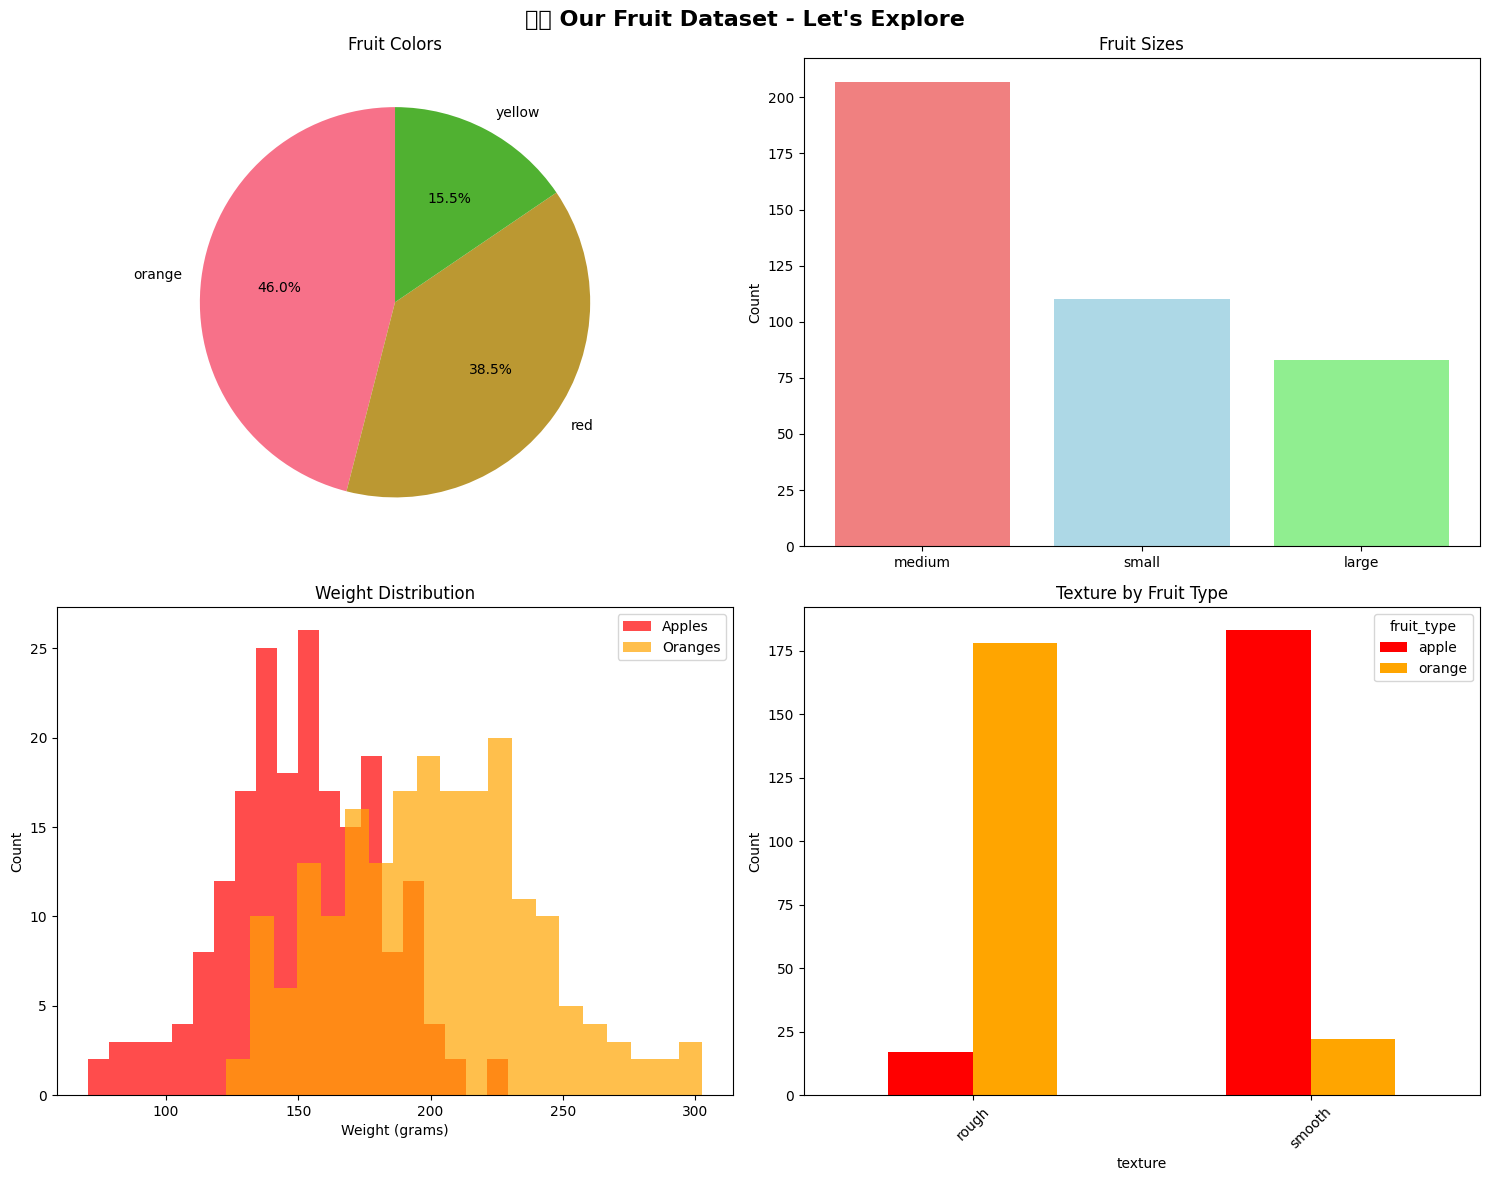


🔍 What do we notice?
• Apples are usually red and smooth
• Oranges are usually orange and rough
• Oranges tend to be heavier than apples
• This should help our computer learn to tell them apart


In [79]:
# Create a big picture to show our fruit data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🍎🍊 Our Fruit Dataset - Let\'s Explore', fontsize=16, fontweight='bold')

# 1. Color distribution
color_counts = df['color'].value_counts()
axes[0,0].pie(color_counts.values, labels=color_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Fruit Colors')

# 2. Size distribution
size_counts = df['size'].value_counts()
axes[0,1].bar(size_counts.index, size_counts.values, color=['lightcoral', 'lightblue', 'lightgreen'])
axes[0,1].set_title('Fruit Sizes')
axes[0,1].set_ylabel('Count')

# 3. Weight distribution by fruit type
apple_weights = df[df['fruit_type'] == 'apple']['weight']
orange_weights = df[df['fruit_type'] == 'orange']['weight']

axes[1,0].hist(apple_weights, alpha=0.7, label='Apples', color='red', bins=20)
axes[1,0].hist(orange_weights, alpha=0.7, label='Oranges', color='orange', bins=20)
axes[1,0].set_title('Weight Distribution')
axes[1,0].set_xlabel('Weight (grams)')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()

# 4. Texture by fruit type
texture_fruit = pd.crosstab(df['texture'], df['fruit_type'])
texture_fruit.plot(kind='bar', ax=axes[1,1], color=['red', 'orange'])
axes[1,1].set_title('Texture by Fruit Type')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n🔍 What do we notice?")
print("• Apples are usually red and smooth")
print("• Oranges are usually orange and rough")
print("• Oranges tend to be heavier than apples")
print("• This should help our computer learn to tell them apart")


## Step 3: Preparing Data for Our Computer

Our computer needs numbers, not words. Let's convert our text features into numbers.


In [80]:
# Convert text features to numbers
df_encoded = df.copy()

# Color: red=0, orange=1, yellow=2
color_mapping = {'red': 0, 'orange': 1, 'yellow': 2}
df_encoded['color_num'] = df_encoded['color'].map(color_mapping)

# Size: small=0, medium=1, large=2
size_mapping = {'small': 0, 'medium': 1, 'large': 2}
df_encoded['size_num'] = df_encoded['size'].map(size_mapping)

# Texture: smooth=0, rough=1
texture_mapping = {'smooth': 0, 'rough': 1}
df_encoded['texture_num'] = df_encoded['texture'].map(texture_mapping)

# Fruit type: apple=0, orange=1
fruit_mapping = {'apple': 0, 'orange': 1}
df_encoded['fruit_type_num'] = df_encoded['fruit_type'].map(fruit_mapping)

# Show the conversion
print("🔄 Converting words to numbers:")
print("\nColor mapping:", color_mapping)
print("Size mapping:", size_mapping)
print("Texture mapping:", texture_mapping)
print("Fruit type mapping:", fruit_mapping)

print("\n📊 Our encoded data (first 10 rows):")
print(df_encoded[['color', 'color_num', 'size', 'size_num', 'texture', 'texture_num', 'weight', 'fruit_type', 'fruit_type_num']].head(10))


🔄 Converting words to numbers:

Color mapping: {'red': 0, 'orange': 1, 'yellow': 2}
Size mapping: {'small': 0, 'medium': 1, 'large': 2}
Texture mapping: {'smooth': 0, 'rough': 1}
Fruit type mapping: {'apple': 0, 'orange': 1}

📊 Our encoded data (first 10 rows):
    color  color_num    size  size_num texture  texture_num      weight  \
0     red          0   large         2  smooth            0  116.643596   
1     red          0   small         0  smooth            0  159.567066   
2     red          0  medium         1  smooth            0  132.573656   
3     red          0  medium         1  smooth            0  134.244906   
4     red          0  medium         1  smooth            0  137.158618   
5     red          0  medium         1  smooth            0  127.727795   
6     red          0  medium         1  smooth            0  153.666575   
7     red          0   small         0   rough            1  134.536930   
8  yellow          2   large         2  smooth            0  15

## Step 4: Training Our Fruit Classifier

Now let's teach our computer to tell apples from oranges.


In [81]:
# Prepare our features (what we use to make predictions)
features = ['color_num', 'size_num', 'texture_num', 'weight']
X = df_encoded[features]  # Features (what we know)
y = df_encoded['fruit_type_num']  # Target (what we want to predict)

print("🎯 Features we're using to predict:")
for i, feature in enumerate(features):
    print(f"{i+1}. {feature}")

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"📊 Target vector shape: {y.shape}")

# Split our data: some for training, some for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\n📚 Training set: {X_train.shape[0]} fruits")
print(f"🧪 Testing set: {X_test.shape[0]} fruits")

# Train our classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on our test set
y_pred = classifier.predict(X_test)

print("\n🤖 Our computer has learned to classify fruits")
print(f"\n📈 Training accuracy: {classifier.score(X_train, y_train):.3f}")
print(f"📈 Test accuracy: {classifier.score(X_test, y_test):.3f}")

# Show some example predictions
print("\n🔮 Some example predictions:")
test_df = X_test.copy()
test_df['actual'] = y_test
test_df['predicted'] = y_pred
test_df['actual_fruit'] = test_df['actual'].map({0: 'apple', 1: 'orange'})
test_df['predicted_fruit'] = test_df['predicted'].map({0: 'apple', 1: 'orange'})
print(test_df[['actual_fruit', 'predicted_fruit']].head(10))


🎯 Features we're using to predict:
1. color_num
2. size_num
3. texture_num
4. weight

📊 Feature matrix shape: (400, 4)
📊 Target vector shape: (400,)

📚 Training set: 280 fruits
🧪 Testing set: 120 fruits

🤖 Our computer has learned to classify fruits

📈 Training accuracy: 0.921
📈 Test accuracy: 0.933

🔮 Some example predictions:
    actual_fruit predicted_fruit
209       orange          orange
280       orange           apple
33         apple           apple
210       orange           apple
93         apple           apple
84         apple           apple
329       orange          orange
94         apple           apple
266       orange          orange
126        apple           apple


## Step 5: Understanding the Confusion Matrix

A confusion matrix is like a scorecard that shows us exactly what our computer got right and wrong.


In [82]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(f"                Predicted")
print(f"                Apple  Orange")
print(f"Actual Apple     {cm[0,0]:3d}     {cm[0,1]:3d}")
print(f"       Orange     {cm[1,0]:3d}     {cm[1,1]:3d}")

# Let's break it down
true_negatives = cm[0,0]  # Correctly identified as apples
false_positives = cm[0,1]  # Apples incorrectly called oranges
false_negatives = cm[1,0]  # Oranges incorrectly called apples
true_positives = cm[1,1]  # Correctly identified as oranges

print(f"\nBreaking it down:")
print(f"✅ True Negatives (TN): {true_negatives} - Correctly identified as apples")
print(f"❌ False Positives (FP): {false_positives} - Apples incorrectly called oranges")
print(f"❌ False Negatives (FN): {false_negatives} - Oranges incorrectly called apples")
print(f"✅ True Positives (TP): {true_positives} - Correctly identified as oranges")


Confusion Matrix:
                Predicted
                Apple  Orange
Actual Apple      60       2
       Orange       6      52

Breaking it down:
✅ True Negatives (TN): 60 - Correctly identified as apples
❌ False Positives (FP): 2 - Apples incorrectly called oranges
❌ False Negatives (FN): 6 - Oranges incorrectly called apples
✅ True Positives (TP): 52 - Correctly identified as oranges


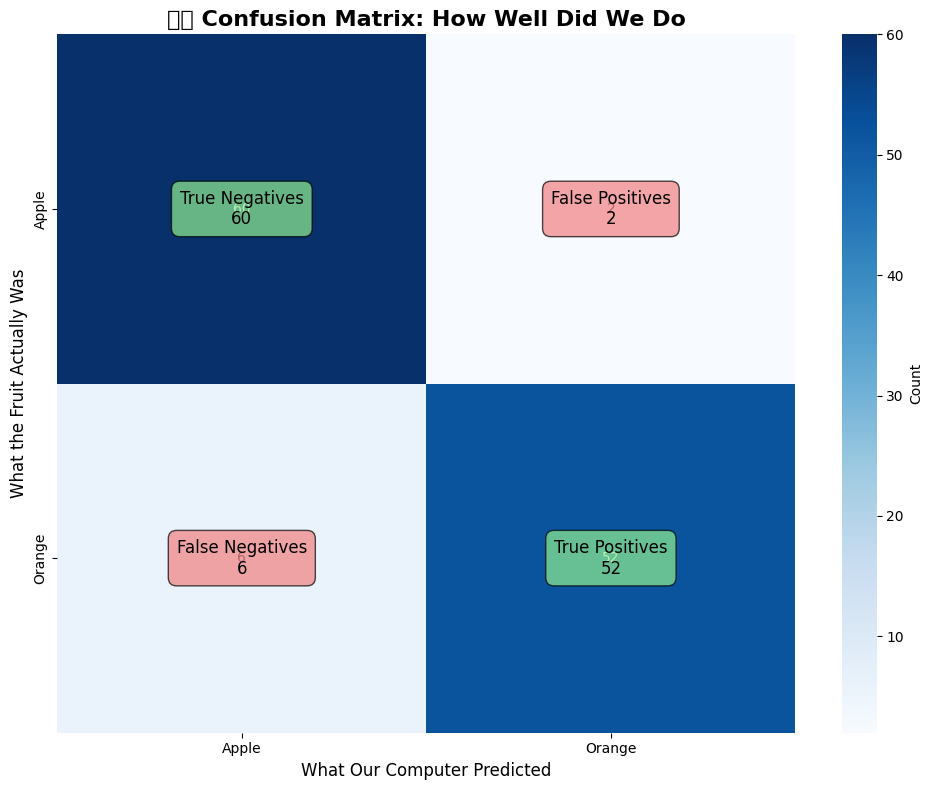


💡 Think of it like this:
• Green boxes = We got it right 🎉
• Red boxes = We made a mistake 😅
• The bigger the green numbers, the better we did


In [83]:
# Create a beautiful confusion matrix visualization
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Apple', 'Orange'], 
            yticklabels=['Apple', 'Orange'],
            cbar_kws={'label': 'Count'})

plt.title('🍎🍊 Confusion Matrix: How Well Did We Do', fontsize=16, fontweight='bold')
plt.xlabel('What Our Computer Predicted', fontsize=12)
plt.ylabel('What the Fruit Actually Was', fontsize=12)

# Add text annotations
plt.text(0.5, 0.5, f'True Negatives\n{true_negatives}', ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7), fontsize=12)
plt.text(1.5, 0.5, f'False Positives\n{false_positives}', ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7), fontsize=12)
plt.text(0.5, 1.5, f'False Negatives\n{false_negatives}', ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7), fontsize=12)
plt.text(1.5, 1.5, f'True Positives\n{true_positives}', ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7), fontsize=12)

plt.tight_layout()
plt.show()

print("\n💡 Think of it like this:")
print("• Green boxes = We got it right 🎉")
print("• Red boxes = We made a mistake 😅")
print("• The bigger the green numbers, the better we did")


## Step 6: Calculating Our Four Important Metrics

Now let's calculate each metric step by step.


In [84]:
# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Our Classification Results:")
print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"Recall:    {recall:.3f} ({recall*100:.1f}%)")
print(f"F1 Score:  {f1:.3f} ({f1*100:.1f}%)")

# Let's also calculate them manually to understand
print("\nStep-by-step calculations:")
print(f"Accuracy: ({true_positives} + {true_negatives}) / ({true_positives} + {true_negatives} + {false_positives} + {false_negatives}) = {(true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives):.3f}")
print(f"Precision: {true_positives} / ({true_positives} + {false_positives}) = {true_positives / (true_positives + false_positives):.3f}")
print(f"Recall: {true_positives} / ({true_positives} + {false_negatives}) = {true_positives / (true_positives + false_negatives):.3f}")
manual_f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: 2 × ({precision:.3f} × {recall:.3f}) / ({precision:.3f} + {recall:.3f}) = {manual_f1:.3f}")


Our Classification Results:
Accuracy:  0.933 (93.3%)
Precision: 0.963 (96.3%)
Recall:    0.897 (89.7%)
F1 Score:  0.929 (92.9%)

Step-by-step calculations:
Accuracy: (52 + 60) / (52 + 60 + 2 + 6) = 0.933
Precision: 52 / (52 + 2) = 0.963
Recall: 52 / (52 + 6) = 0.897
F1 Score: 2 × (0.963 × 0.897) / (0.963 + 0.897) = 0.929


## Step 7: Visualizing Our Metrics

Let's create some cool visualizations to understand our metrics better.


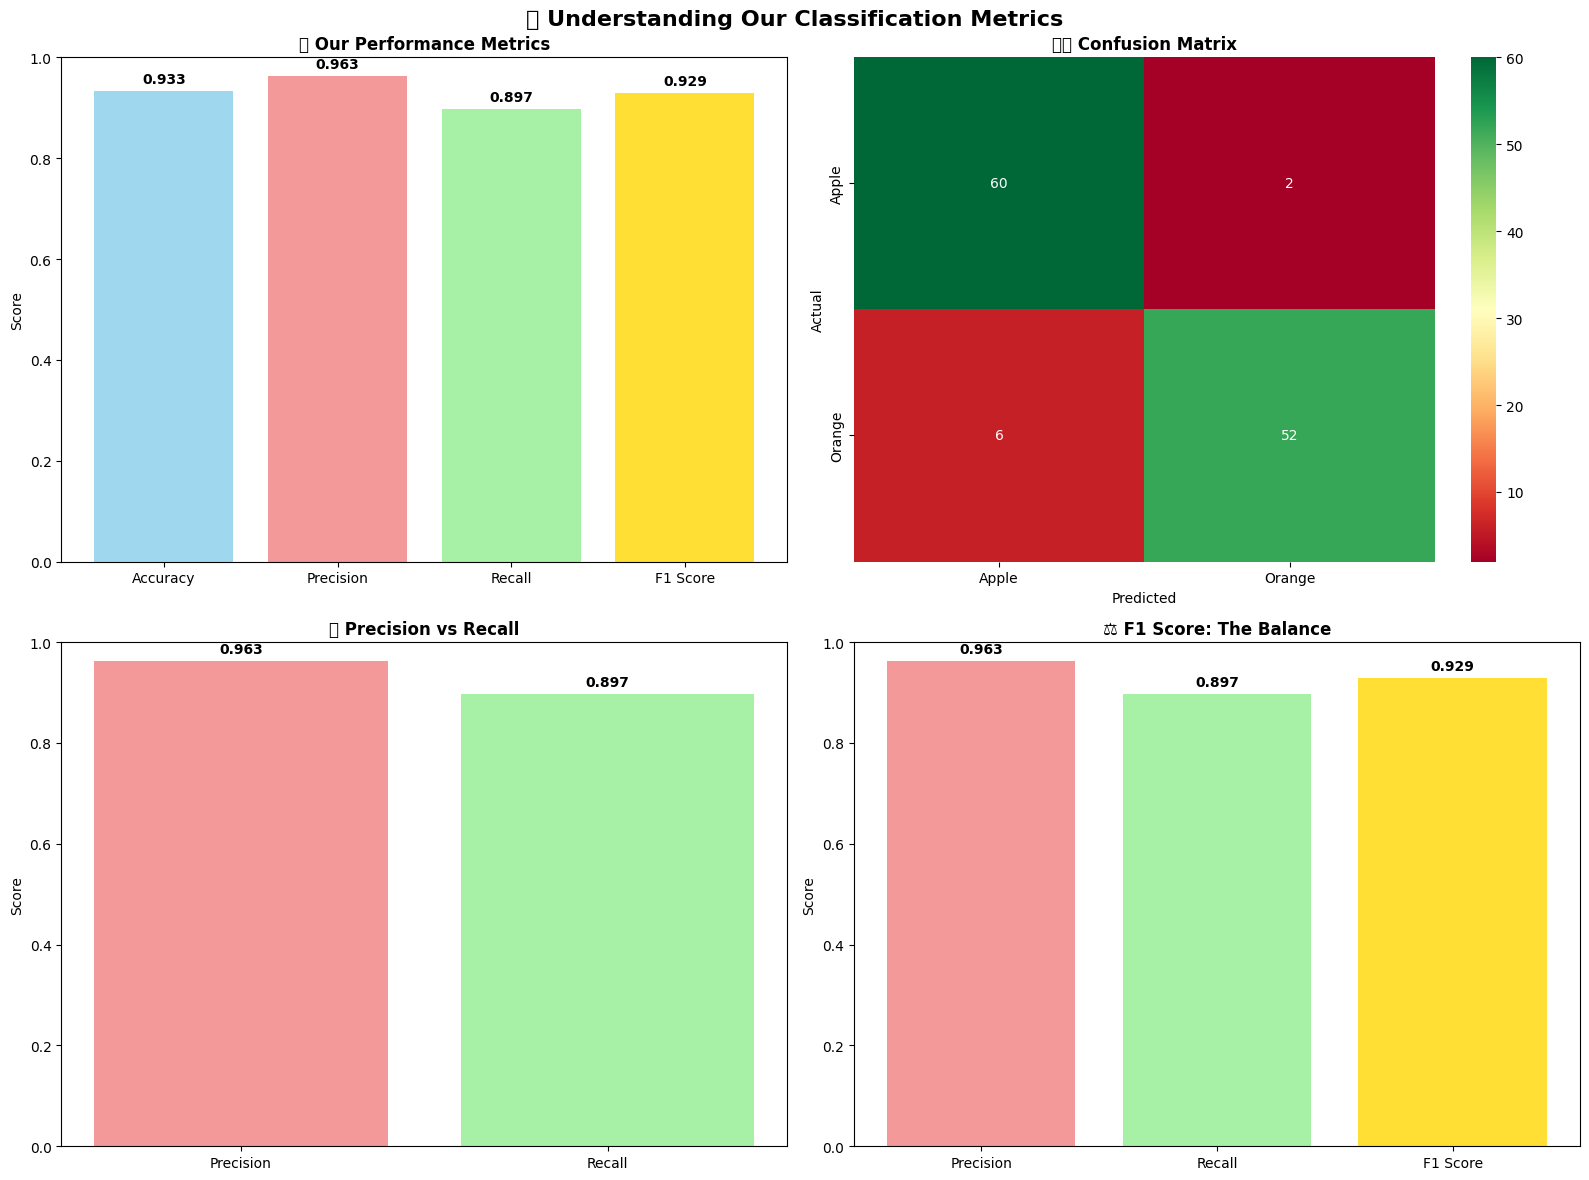


Our performance:
• Accuracy: 93.3% - we're right 93.3% of the time
• Precision: 96.3% - when we say 'orange', we're right 96.3% of the time
• Recall: 89.7% - we found 89.7% of all the real oranges
• F1 Score: 92.9% - a balanced measure of both precision and recall


In [85]:
# Create a comprehensive visualization of our metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Understanding Our Classification Metrics', fontsize=16, fontweight='bold')

# 1. Metrics Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = axes[0,0].bar(metrics, values, color=colors, alpha=0.8)
axes[0,0].set_title('🎯 Our Performance Metrics', fontweight='bold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix (simplified)
cm_simple = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0,1],
            xticklabels=['Apple', 'Orange'], yticklabels=['Apple', 'Orange'])
axes[0,1].set_title('🍎🍊 Confusion Matrix', fontweight='bold')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Precision vs Recall
categories = ['Precision', 'Recall']
pr_values = [precision, recall]
axes[1,0].bar(categories, pr_values, color=['lightcoral', 'lightgreen'], alpha=0.8)
axes[1,0].set_title('🎯 Precision vs Recall', fontweight='bold')
axes[1,0].set_ylabel('Score')
axes[1,0].set_ylim(0, 1)

# Add value labels
for i, (cat, val) in enumerate(zip(categories, pr_values)):
    axes[1,0].text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. F1 Score explanation
f1_components = ['Precision', 'Recall', 'F1 Score']
f1_values = [precision, recall, f1]
axes[1,1].bar(f1_components, f1_values, color=['lightcoral', 'lightgreen', 'gold'], alpha=0.8)
axes[1,1].set_title('⚖️ F1 Score: The Balance', fontweight='bold')
axes[1,1].set_ylabel('Score')
axes[1,1].set_ylim(0, 1)

# Add value labels
for i, (comp, val) in enumerate(zip(f1_components, f1_values)):
    axes[1,1].text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nOur performance:")
print(f"• Accuracy: {accuracy:.1%} - we're right {accuracy:.1%} of the time")
print(f"• Precision: {precision:.1%} - when we say 'orange', we're right {precision:.1%} of the time")
print(f"• Recall: {recall:.1%} - we found {recall:.1%} of all the real oranges")
print(f"• F1 Score: {f1:.1%} - a balanced measure of both precision and recall")


## Step 8: What Each Metric Means in Simple Terms

Let's break down each metric with simple explanations and examples.


## Understanding Each Metric

### 1️⃣ **ACCURACY - The Overall Report Card**
- **What it means**: Out of all our predictions, how many were correct?
- **Our result**: We got it right most of the time
- **Example**: If we looked at 100 fruits, we'd correctly identify most of them
- **When to use**: When both types of mistakes are equally bad
- **When NOT to use**: When one type of mistake is much worse than the other

### 2️⃣ **PRECISION - The 'Cry Wolf' Meter**
- **What it means**: When we say 'orange', how often are we actually right?
- **Our result**: When we say 'orange', we're usually right
- **Example**: If we said 'orange' 10 times, most of those would actually be oranges
- **When to use**: When false alarms are expensive or annoying
- **When NOT to use**: When we need to catch every single case

### 3️⃣ **RECALL - The 'Catch Them All' Meter**
- **What it means**: Of all the real oranges, how many did we successfully find?
- **Our result**: We found most of all the real oranges
- **Example**: If there were 100 real oranges, we'd find most of them
- **When to use**: When missing something is very dangerous
- **When NOT to use**: When false alarms are very expensive

### 4️⃣ **F1 SCORE - The Balanced Report Card**
- **What it means**: A balanced measure that considers both precision and recall
- **Our result**: A balanced score that considers both aspects
- **Example**: If precision and recall are both important, F1 gives us the best balance
- **When to use**: When we need a single number that balances both concerns
- **When NOT to use**: When one metric is clearly more important than the other


## Step 9: Real-World Examples - When Each Metric Matters Most

Let's explore real-world scenarios where each metric is most important.


## Real-World Examples: When Each Metric Matters Most

### 🎯 **ACCURACY - When Overall Performance Matters**

**📚 Example 1: Email Spam Detection**
- You want to correctly identify both spam and real emails
- Both mistakes are equally annoying (missing important email vs getting spam)
- High accuracy means you're right most of the time overall

**📚 Example 2: Weather Prediction**
- You want to be right about both sunny and rainy days
- Both types of mistakes are equally inconvenient
- High accuracy means reliable weather forecasts

### 🎯 **PRECISION - When False Alarms Are Expensive**

**🚨 Example 1: Medical Diagnosis (Cancer Screening)**
- When you say 'cancer', you better be right
- False alarms cause unnecessary stress and expensive tests
- High precision means when you say 'cancer', you're usually right

**🚨 Example 2: Security Systems**
- When the alarm goes off, you want it to be a real threat
- False alarms waste time and resources
- High precision means fewer false alarms

### 🎯 **RECALL - When Missing Something Is Dangerous**

**🏥 Example 1: Disease Detection**
- You want to catch every single case of a serious disease
- Missing a real case could be life-threatening
- High recall means you find almost all the real cases

**🏥 Example 2: Fraud Detection**
- You want to catch every fraudulent transaction
- Missing fraud costs money
- High recall means you catch almost all fraud

### 🎯 **F1 SCORE - When You Need Balance**

**⚖️ Example 1: Email Classification**
- You want to correctly identify both work and personal emails
- Both precision and recall matter equally
- High F1 means good balance between both concerns

**⚖️ Example 2: Product Recommendation**
- You want to recommend products people will actually buy
- Both accuracy of recommendations and coverage matter
- High F1 means good balance between relevance and coverage


## Step 10: Interactive Examples - Let's Test Our Understanding

Let's create some scenarios to test our understanding of these metrics.


## Interactive Examples - Test Your Understanding

### 📝 **Scenario 1: The Overly Cautious Security Guard**
A security guard at a school is very cautious about letting people in.
- He checks EVERYONE very carefully
- He rarely lets in anyone suspicious (high precision)
- But he also turns away many legitimate visitors (low recall)

**🎯 Which metric would be most important here?**
- A) Accuracy  B) Precision  C) Recall  D) F1 Score

**💡 Answer: B) Precision** - We want to be right when we say 'suspicious'

### 📝 **Scenario 2: The Medical Screening Test**
A doctor is screening patients for a serious disease.
- The disease is treatable if caught early
- Missing a case could be life-threatening
- False alarms cause stress but are manageable

**🎯 Which metric would be most important here?**
- A) Accuracy  B) Precision  C) Recall  D) F1 Score

**💡 Answer: C) Recall** - We must catch every real case

### 📝 **Scenario 3: The Email Spam Filter**
An email system needs to filter spam from important emails.
- Missing important emails is bad
- Getting spam in your inbox is also bad
- Both types of mistakes are equally annoying

**🎯 Which metric would be most important here?**
- A) Accuracy  B) Precision  C) Recall  D) F1 Score

**💡 Answer: A) Accuracy** - We want to be right overall

### 📝 **Scenario 4: The Product Recommendation System**
An online store wants to recommend products to customers.
- You want recommendations to be relevant (precision)
- You also want to cover many products (recall)
- Both aspects are important for customer satisfaction

**🎯 Which metric would be most important here?**
- A) Accuracy  B) Precision  C) Recall  D) F1 Score

**💡 Answer: D) F1 Score** - We need a balance of both precision and recall


## Step 11: The Trade-offs Between Metrics

Sometimes improving one metric makes another worse. Let's explore these trade-offs.


## The Trade-offs Between Metrics

### 🔄 **Precision vs Recall Trade-off**

**📈 High Precision, Low Recall:**
- Like a very picky fruit inspector
- Only says 'orange' when 100% sure
- Result: Few mistakes, but misses many oranges

**📈 Low Precision, High Recall:**
- Like a very cautious fruit inspector
- Says 'orange' for anything that might be orange
- Result: Finds most oranges, but makes many mistakes

### 🎯 **Real-World Example: Email Spam Detection**

**📧 Conservative Approach (High Precision):**
- Only mark emails as spam when very sure
- Result: Few false positives, but some spam gets through

**📧 Aggressive Approach (High Recall):**
- Mark emails as spam when they might be spam
- Result: Catch most spam, but some real emails marked as spam

### 💡 **The Key Insight:**
- You can't always have both high precision AND high recall
- The choice depends on what's more important for your situation
- F1 score helps balance these competing concerns

### 🎨 **Visualizing the Trade-off:**
Imagine a seesaw:
- One side = Precision
- Other side = Recall
- When one goes up, the other tends to go down
- F1 score is like finding the perfect balance point


## Step 12: Summary - What We've Learned

Let's summarize everything we've learned about classification metrics.


## Summary: What We've Learned About Classification Metrics

### 📊 **The Four Key Metrics:**

**1️⃣ ACCURACY - The Overall Report Card**
- Formula: (TP + TN) / (TP + TN + FP + FN)
- Use when: Both types of mistakes are equally bad
- Example: Weather prediction, email spam detection

**2️⃣ PRECISION - The 'Cry Wolf' Meter**
- Formula: TP / (TP + FP)
- Use when: False alarms are expensive
- Example: Medical diagnosis, security systems

**3️⃣ RECALL - The 'Catch Them All' Meter**
- Formula: TP / (TP + FN)
- Use when: Missing something is dangerous
- Example: Disease detection, fraud detection

**4️⃣ F1 SCORE - The Balanced Report Card**
- Formula: 2 × (Precision × Recall) / (Precision + Recall)
- Use when: You need a balance of both precision and recall
- Example: Product recommendations, email classification

### 💡 **Key Takeaways:**
- Different metrics measure different aspects of performance
- The best metric depends on your specific situation
- Sometimes you can't have both high precision AND high recall
- F1 score helps balance competing concerns
- Always consider the real-world impact of your choices

### 🎉 **Congratulations**
You now understand classification metrics. You can use these concepts to evaluate any classification model. Remember: The best metric is the one that makes sense for your problem.


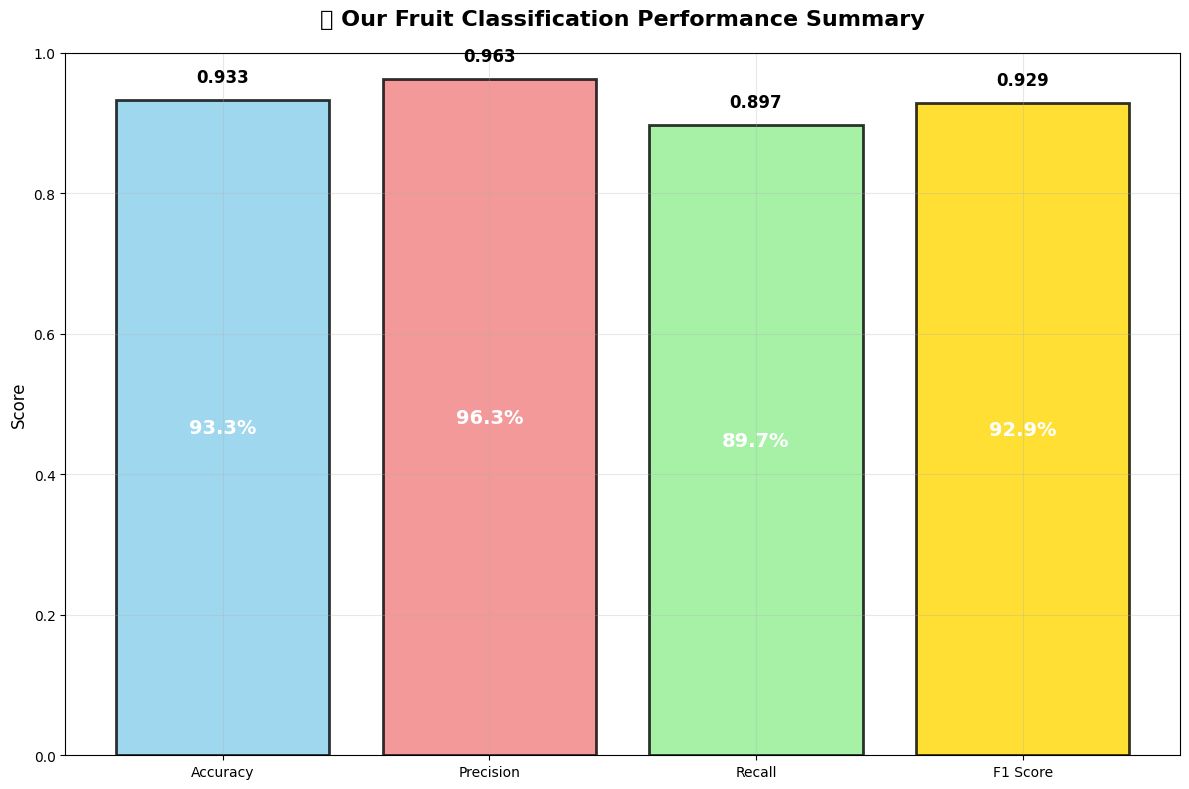


The chart above shows our complete performance summary
Each bar represents how well we did on that particular metric
The higher the bar, the better our performance
🎉 Great job learning about classification metrics 🎉


In [86]:
# Create a final visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Create a radar chart of our metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

# Create bars
bars = ax.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Customize the plot
ax.set_title('🎯 Our Fruit Classification Performance Summary', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
           f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Add percentage labels
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
           f'{value:.1%}', ha='center', va='center', fontweight='bold', fontsize=14, color='white')

plt.tight_layout()
plt.show()

print("\nThe chart above shows our complete performance summary")
print("Each bar represents how well we did on that particular metric")
print("The higher the bar, the better our performance")
print("🎉 Great job learning about classification metrics 🎉")
